In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import statsmodels.api as sm

%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
%load_ext google.cloud.bigquery

In [3]:
%%bigquery df --use_bqstorage_api
SELECT * FROM `draftkings-287323.nba.box_score_stats`

In [4]:
df['minutes_played'] = df.seconds_played / 60

In [5]:
df.head()

,slug,name,team,location,opponent,date_played,outcome,seconds_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,attempted_three_point_field_goals,made_free_throws,attempted_free_throws,total_points_scored,total_rebounds,assists,steals,blocks,turnovers,double_double_flag,triple_double_flag,draftkings_points,minutes_played
0,gayru01,Rudy Gay,Team.TORONTO_RAPTORS,Location.HOME,Team.NEW_YORK_KNICKS,2013-02-22,Outcome.WIN,2481,11,23,1,4,9,11,32,7,2,2,0,2,0,0,47.25,41.350000
1,gayru01,Rudy Gay,Team.TORONTO_RAPTORS,Location.HOME,Team.CHARLOTTE_BOBCATS,2013-03-15,Outcome.WIN,2147,11,16,1,3,5,5,28,3,2,1,1,6,0,0,36.25,35.783333
2,gayru01,Rudy Gay,Team.TORONTO_RAPTORS,Location.HOME,Team.DETROIT_PISTONS,2013-04-01,Outcome.LOSS,2416,13,18,4,4,4,4,34,6,5,1,1,1,0,0,54.50,40.266667
3,gayru01,Rudy Gay,Team.TORONTO_RAPTORS,Location.AWAY,Team.INDIANA_PACERS,2013-11-08,Outcome.LOSS,2113,12,26,2,5,4,4,30,4,0,3,3,2,0,0,47.00,35.216667
4,gayru01,Rudy Gay,Team.TORONTO_RAPTORS,Location.AWAY,Team.HOUSTON_ROCKETS,2013-11-11,Outcome.LOSS,2963,11,37,3,8,4,4,29,10,2,4,1,2,1,0,56.50,49.383333


In [6]:
df.shape

(265570, 24)

## Helper Functions

In [7]:
def custom_round(x, base=5):
    return base * round(x / base)

In [8]:
def check_missing_values(data):
    """Checks Missing Values By Column in Data"""
    df_count_missing = pd.DataFrame({
        'number_total_rows': data.shape[0],
        'number_missing_rows': data.isnull().sum(),
        'percentage': data.isnull().mean()})
    return df_count_missing

In [9]:
def create_corr_heatmap(data):
    """
    Create the correlation heatmap of a dataframe

    Taken from: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    Keyword Args:
      data: DataFrame with data
    """
    corr = data.corr()
    sns.set(style="white")

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5})
    return heatmap

In [10]:
def split_dataset(dataset, train_percentage, feature_headers, target_header):
    """
    Split the dataset with train_percentage
    
    Keyword Args:
    dataset: The Actual Dataset
    train_percentage: Percentage of Dataset to split into Training
    feature_headers: columns that are features to include
    target_header: column that is the outcome variable of interest
    :return: train_x, test_x, train_y, test_y
    """

    # Split dataset into train and test dataset
    train_x, test_x, train_y, test_y = train_test_split(dataset[feature_headers], dataset[target_header],
                                                        train_size=train_percentage)
    return train_x, test_x, train_y, test_y

## Data Exploration

In [11]:
check_missing_values(df)

,number_total_rows,number_missing_rows,percentage
slug,265570,0,0.0
name,265570,0,0.0
team,265570,0,0.0
location,265570,0,0.0
opponent,265570,0,0.0
date_played,265570,0,0.0
outcome,265570,0,0.0
seconds_played,265570,0,0.0
made_field_goals,265570,0,0.0
attempted_field_goals,265570,0,0.0


/Users/vincela/.pyenv/versions/3.7.4/envs/draftkings/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


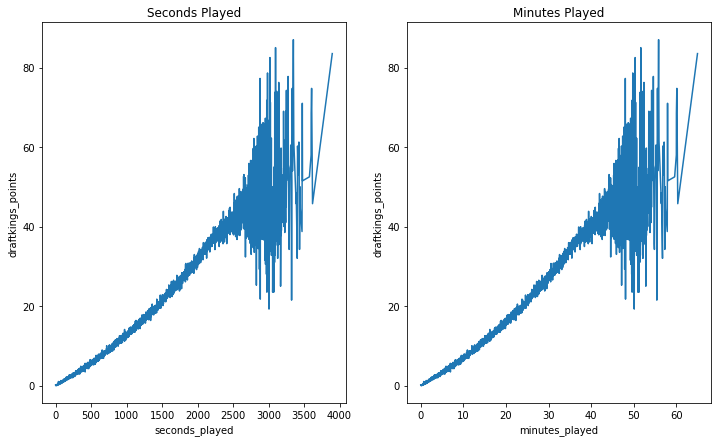

In [12]:
fig, ax_lst = plt.subplots(1, 2, figsize=(12, 7))
ax_lst = np.ravel(ax_lst)

# Setting ci=None is important for run time since otherwise it tries to compute very expensive error bars
# By default groups by the mean
sns.lineplot(x='seconds_played', y='draftkings_points', data=df, ax=ax_lst[0], ci=None)
sns.lineplot(x='minutes_played', y='draftkings_points', data=df, ax=ax_lst[1], ci=None)

ax_lst[0].set_title('Seconds Played')
ax_lst[1].set_title('Minutes Played')

fig.show()

/Users/vincela/.pyenv/versions/3.7.4/envs/draftkings/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


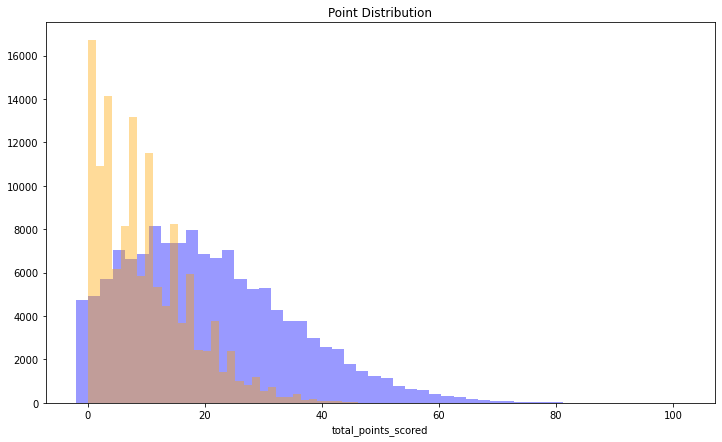

In [13]:
fig, ax_lst = plt.subplots(1, 1, figsize=(12, 7))
ax_lst = np.ravel(ax_lst)

# Setting ci=None is important for run time since otherwise it tries to compute very expensive error bars
# By default groups by the mean
sns.distplot(a=df.loc[df.location == 'Location.HOME'].draftkings_points, ax=ax_lst[0], hist=True, kde=False, color='blue')
sns.distplot(a=df.loc[df.location == 'Location.AWAY'].total_points_scored, ax=ax_lst[0], hist=True, kde=False, color='orange')

ax_lst[0].set_title('Point Distribution')

fig.show()

<AxesSubplot:>

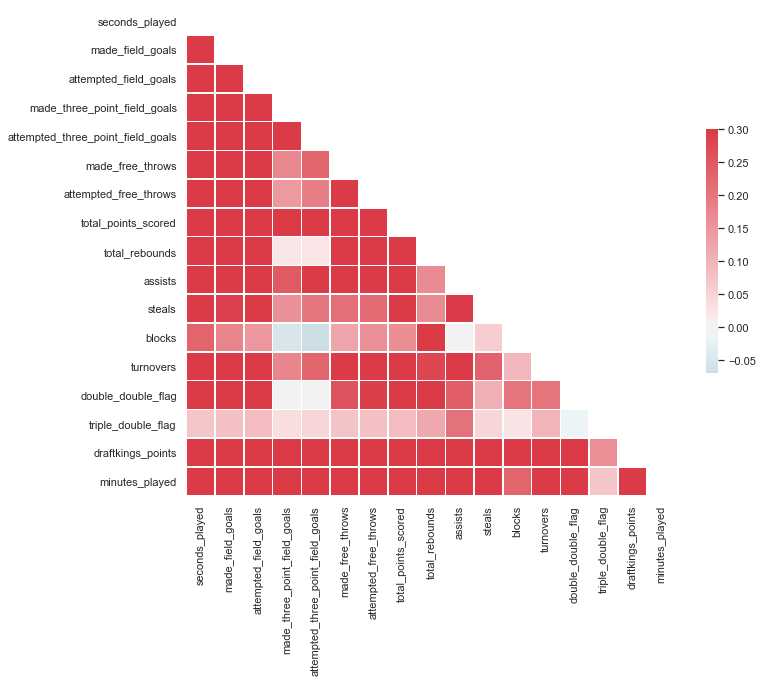

In [14]:
create_corr_heatmap(df)

## Doing Some Basic Regression Models

In [15]:
df.head()

,slug,name,team,location,opponent,date_played,outcome,seconds_played,made_field_goals,attempted_field_goals,made_three_point_field_goals,attempted_three_point_field_goals,made_free_throws,attempted_free_throws,total_points_scored,total_rebounds,assists,steals,blocks,turnovers,double_double_flag,triple_double_flag,draftkings_points,minutes_played
0,gayru01,Rudy Gay,Team.TORONTO_RAPTORS,Location.HOME,Team.NEW_YORK_KNICKS,2013-02-22,Outcome.WIN,2481,11,23,1,4,9,11,32,7,2,2,0,2,0,0,47.25,41.350000
1,gayru01,Rudy Gay,Team.TORONTO_RAPTORS,Location.HOME,Team.CHARLOTTE_BOBCATS,2013-03-15,Outcome.WIN,2147,11,16,1,3,5,5,28,3,2,1,1,6,0,0,36.25,35.783333
2,gayru01,Rudy Gay,Team.TORONTO_RAPTORS,Location.HOME,Team.DETROIT_PISTONS,2013-04-01,Outcome.LOSS,2416,13,18,4,4,4,4,34,6,5,1,1,1,0,0,54.50,40.266667
3,gayru01,Rudy Gay,Team.TORONTO_RAPTORS,Location.AWAY,Team.INDIANA_PACERS,2013-11-08,Outcome.LOSS,2113,12,26,2,5,4,4,30,4,0,3,3,2,0,0,47.00,35.216667
4,gayru01,Rudy Gay,Team.TORONTO_RAPTORS,Location.AWAY,Team.HOUSTON_ROCKETS,2013-11-11,Outcome.LOSS,2963,11,37,3,8,4,4,29,10,2,4,1,2,1,0,56.50,49.383333


In [16]:
df_ml = df[['slug', 'date_played', 'draftkings_points']].copy(deep=True)

In [17]:
df_ml.head(), df_ml.shape

(      slug date_played  draftkings_points
 0  gayru01  2013-02-22              47.25
 1  gayru01  2013-03-15              36.25
 2  gayru01  2013-04-01              54.50
 3  gayru01  2013-11-08              47.00
 4  gayru01  2013-11-11              56.50,
 (265570, 3))

In [18]:
df_ml.sort_values(by=['slug', 'date_played'], inplace=True)

In [19]:
df_ml.head()

,slug,date_played,draftkings_points
81983,abrinal01,2016-10-26,3.75
89073,abrinal01,2016-10-30,7.00
92436,abrinal01,2016-11-02,6.00
89074,abrinal01,2016-11-03,10.75
75749,abrinal01,2016-11-05,8.50


In [20]:
df_ml['draftkings_points_lag'] = df_ml.groupby(['slug'])['draftkings_points'].shift(1)
df_ml['draftkings_points_lag_2'] = df_ml.groupby(['slug'])['draftkings_points'].shift(2)
df_ml['draftkings_points_lag_3'] = df_ml.groupby(['slug'])['draftkings_points'].shift(3)
df_ml['draftkings_points_lag_4'] = df_ml.groupby(['slug'])['draftkings_points'].shift(4)
df_ml['draftkings_points_lag_5'] = df_ml.groupby(['slug'])['draftkings_points'].shift(5)

In [21]:
df_ml.head()

,slug,date_played,draftkings_points,draftkings_points_lag,draftkings_points_lag_2,draftkings_points_lag_3,draftkings_points_lag_4,draftkings_points_lag_5
81983,abrinal01,2016-10-26,3.75,NaN,NaN,NaN,NaN,NaN
89073,abrinal01,2016-10-30,7.00,3.75,NaN,NaN,NaN,NaN
92436,abrinal01,2016-11-02,6.00,7.00,3.75,NaN,NaN,NaN
89074,abrinal01,2016-11-03,10.75,6.00,7.00,3.75,NaN,NaN
75749,abrinal01,2016-11-05,8.50,10.75,6.00,7.00,3.75,NaN


In [22]:
# As a simplification drop a row if contain any NA
# This is basically saying we can't make a prediction for the first 5 games (or as many as we created lag variables)
df_ml.dropna(how='any', inplace=True)

In [23]:
df_ml.head()

,slug,date_played,draftkings_points,draftkings_points_lag,draftkings_points_lag_2,draftkings_points_lag_3,draftkings_points_lag_4,draftkings_points_lag_5
89075,abrinal01,2016-11-07,9.00,8.50,10.75,6.00,7.00,3.75
81984,abrinal01,2016-11-09,3.00,9.00,8.50,10.75,6.00,7.00
81985,abrinal01,2016-11-11,3.75,3.00,9.00,8.50,10.75,6.00
96335,abrinal01,2016-11-13,10.75,3.75,3.00,9.00,8.50,10.75
89076,abrinal01,2016-11-14,7.75,10.75,3.75,3.00,9.00,8.50


### OLS Regression

In [24]:
feature_headers = [
    'draftkings_points_lag',
    'draftkings_points_lag_2',
    'draftkings_points_lag_3',
    'draftkings_points_lag_4',
    'draftkings_points_lag_5'
]
target_header = 'draftkings_points'
X = df_ml[feature_headers]
y = df_ml[target_header]

#### Using Sci-Kit Learn

In [25]:
train_x, test_x, train_y, test_y = split_dataset(
    dataset=pd.concat([X, y], axis=1),
    train_percentage=0.8,
    feature_headers=feature_headers,
    target_header=target_header)

In [26]:
model = linear_model.LinearRegression()
model.fit(train_x, train_y)

LinearRegression()

In [27]:
model.coef_

array([0.23997409, 0.18364435, 0.15607456, 0.14249051, 0.14814478])

In [28]:
train_y_pred = model.predict(train_x)
test_y_pred = model.predict(test_x)

In [29]:
model.score(train_x, train_y)

0.5246854704480457

In [30]:
model.score(test_x, test_y)

0.5294054373227074

In [31]:
mean_squared_error(train_y, train_y_pred)

93.78532125571284

In [32]:
mean_squared_error(test_y, test_y_pred)

93.83821874021052

#### Using StatsModels

In [33]:
X_sm = X.copy(deep=True)
X_sm['_cons'] = 1

In [34]:
model_sm = sm.OLS(y, X_sm)
res = model_sm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      draftkings_points   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                 5.745e+04
Date:                Mon, 24 Aug 2020   Prob (F-statistic):               0.00
Time:                        23:23:28   Log-Likelihood:            -9.5651e+05
No. Observations:              259251   AIC:                         1.913e+06
Df Residuals:                  259245   BIC:                         1.913e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
draftkings_points_lag     

/Users/vincela/.pyenv/versions/3.7.4/envs/draftkings/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


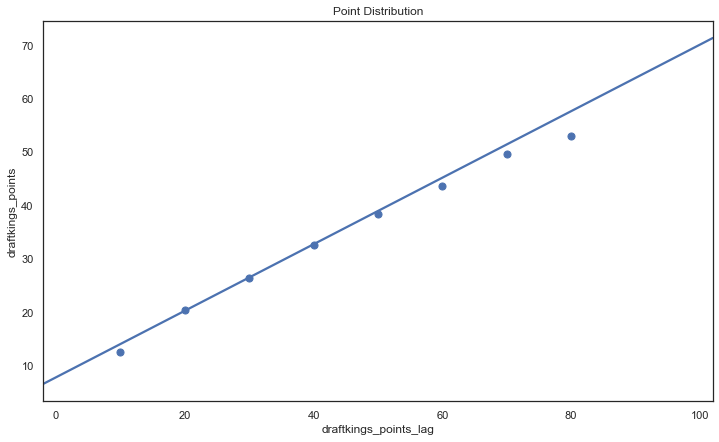

In [35]:
fig, ax_lst = plt.subplots(1, 1, figsize=(12, 7))
ax_lst = np.ravel(ax_lst)

# Setting ci=None is important for run time since otherwise it tries to compute very expensive error bars
# By default groups by the mean
sns.regplot(x=df_ml.draftkings_points_lag, y=df_ml.draftkings_points, ax=ax_lst[0], x_bins=[10, 20, 30, 40, 50, 60, 70, 80], x_ci=None, ci=None)

ax_lst[0].set_title('Point Distribution')

fig.show()

In [36]:
train_results = pd.DataFrame({
    'train_y_pred': train_y_pred,
    'train_y': train_y,
})
test_results = pd.DataFrame({
    'test_y_pred': test_y_pred,
    'test_y': test_y,
})

In [37]:
train_results['train_y_pred_rounded'] = train_results['train_y_pred'].apply(custom_round, base=5)
train_results['train_y_rounded'] = train_results['train_y_pred'].apply(custom_round, base=5)

/Users/vincela/.pyenv/versions/3.7.4/envs/draftkings/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


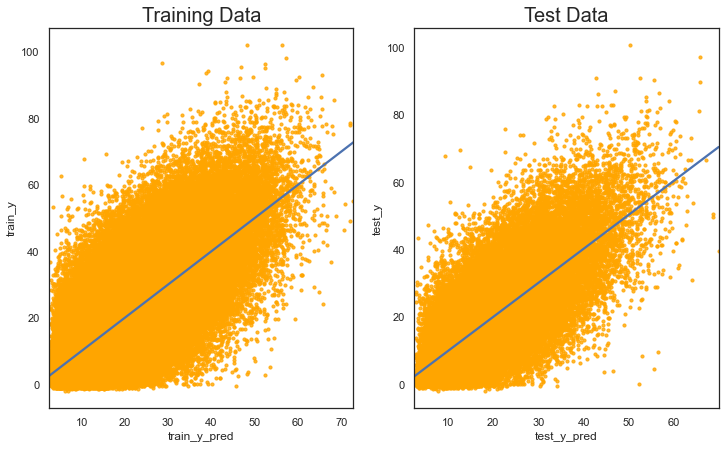

In [38]:
fig, ax_lst = plt.subplots(1, 2, figsize=(12, 7))
ax_lst = np.ravel(ax_lst)

# Setting ci=None is important for run time since otherwise it tries to compute very expensive error bars
# By default groups by the mean
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html for options for scatter_kws
sns.regplot(x='train_y_pred', y='train_y', data=train_results, ax=ax_lst[0], ci=None, scatter_kws={"s": 10, 'color': 'orange'})
sns.regplot(x='test_y_pred', y='test_y', data=test_results, ax=ax_lst[1], ci=None, scatter_kws={'s': 10, 'color': 'orange'})

ax_lst[0].set_title('Training Data', fontsize=20)
ax_lst[1].set_title('Test Data', fontsize=20)

fig.show()

/Users/vincela/.pyenv/versions/3.7.4/envs/draftkings/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


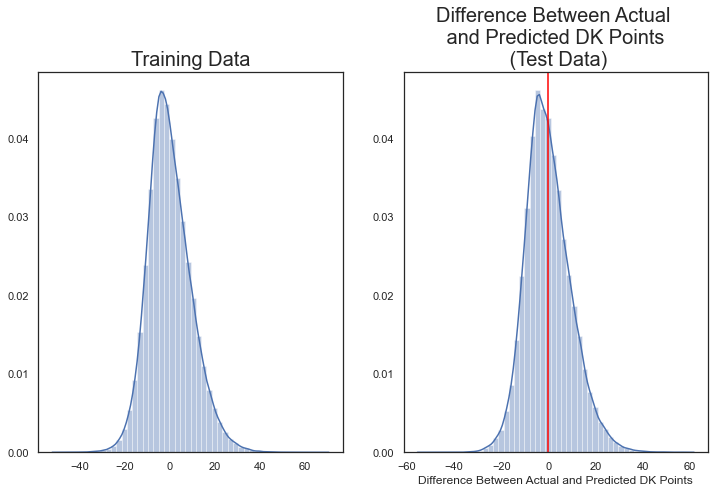

In [39]:
fig, ax_lst = plt.subplots(1, 2, figsize=(12, 7))
ax_lst = np.ravel(ax_lst)

# Setting ci=None is important for run time since otherwise it tries to compute very expensive error bars
# By default groups by the mean
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html for options for scatter_kws
sns.distplot(a=train_results.train_y - train_results.train_y_pred, ax=ax_lst[0])
sns.distplot(a=test_results.test_y - test_results.test_y_pred, ax=ax_lst[1])

ax_lst[0].set_title('Training Data', fontsize=20)
ax_lst[1].set_title('Difference Between Actual \n and Predicted DK Points \n (Test Data)', fontsize=20)
ax_lst[1].set_xlabel('Difference Between Actual and Predicted DK Points')
ax_lst[1].axvline(0, color='red')

fig.show()

### Random Forest Regression

In [41]:
# RandomForestRegModel = RandomForestRegressor()
# RandomForestRegModel.fit(train_x, train_y)

RandomForestRegressor()

In [48]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
RandomForestRegModel = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
RandomForestRegModel_random = RandomizedSearchCV(
    estimator=RandomForestRegModel,
    param_distributions=random_grid,
    n_iter = 2,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs = -1)
# Fit the random search model
RandomForestRegModel_random.fit(train_x, train_y)

RandomForestRegModel = RandomForestRegModel_random.best_estimator_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  2.4min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 14.5min finished


In [49]:
train_y_pred_rf = RandomForestRegModel.predict(train_x)
test_y_pred_rf = RandomForestRegModel.predict(test_x)

/Users/vincela/.pyenv/versions/3.7.4/envs/draftkings/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


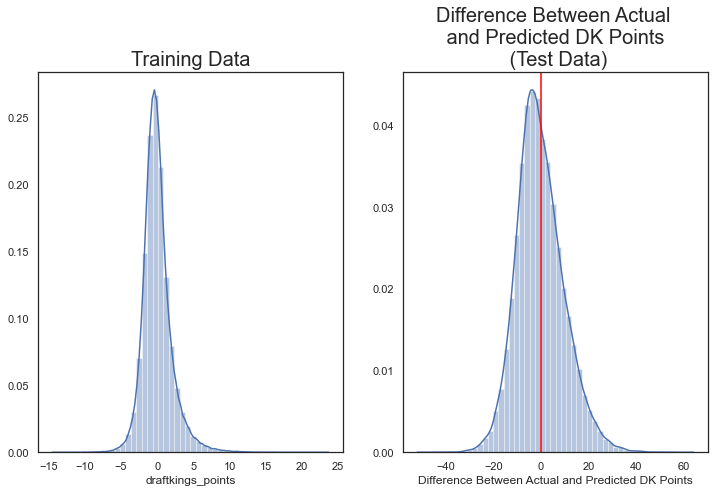

In [50]:
fig, ax_lst = plt.subplots(1, 2, figsize=(12, 7))
ax_lst = np.ravel(ax_lst)

# Setting ci=None is important for run time since otherwise it tries to compute very expensive error bars
# By default groups by the mean
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html for options for scatter_kws
sns.distplot(a=train_y - train_y_pred_rf, ax=ax_lst[0])
sns.distplot(a=test_y - test_y_pred_rf, ax=ax_lst[1])

ax_lst[0].set_title('Training Data', fontsize=20)
ax_lst[1].set_title('Difference Between Actual \n and Predicted DK Points \n (Test Data)', fontsize=20)
ax_lst[1].set_xlabel('Difference Between Actual and Predicted DK Points')
ax_lst[1].axvline(0, color='red')

fig.show()

In [51]:
mean_squared_error(test_y, test_y_pred_rf)

99.48638977027174